In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from gammapy.data import DataStore
from gammapy.scripts import SpectrumAnalysisIACT

# Convenience classes to define analsys inputs
# At some point we'll add a convenience layer to run the analysis starting from a plain text config file.
from gammapy.utils.energy import EnergyBounds
from gammapy.image import SkyImage
from gammapy.spectrum import models
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

In [2]:
store_dir = './'
data_store = DataStore.from_dir(store_dir)
obs_id = data_store.obs_table['OBS_ID'].data
print("Use observations {}".format(obs_id))

obs_list = data_store.obs_list(obs_id)

Use observations [87658]


In [123]:
crab_pos = SkyCoord.from_name('crab')
on_region = CircleSkyRegion(crab_pos, 0.1 * u.deg)

model = models.LogParabola(
    alpha = 2.3,
    beta = 0,
    amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference = 1 * u.TeV,
)

model = models.PowerLaw(
    index = 2.3,
    amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference = 1 * u.TeV,
)

flux_point_binning = EnergyBounds.equal_log_spacing(0.1778, 3.9811, 9, u.TeV)

exclusion_mask = SkyImage.read('$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits')


In [124]:
config = dict(
    outdir = None,
    background = dict(
        on_region=on_region,
        exclusion_mask=exclusion_mask,
        min_distance = 0.1 * u.rad,
    ),
    extraction = dict(containment_correction=False),
    fit = dict(
        model=model,
        stat='wstat',
        forward_folded=True,
        fit_range = flux_point_binning[[0, -1]]
    ),
    fp_binning=flux_point_binning
)

In [125]:
ana = SpectrumAnalysisIACT(
    observations=obs_list,
    config=config,
)
ana.run()

In [126]:
print(ana.fit.result[0])


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit      min max frozen
	--------- --------- --------- --------------- --- --- ------
	    index 2.245e+00 1.135e-01                 nan nan  False
	amplitude 2.766e-11 2.990e-12 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00 0.000e+00             TeV nan nan   True

Covariance: 

	name/name  index   amplitude
	--------- -------- ---------
	    index   0.0129  -2.2e-13
	amplitude -2.2e-13  8.94e-24 

Statistic: 26.909 (wstat)
Fit Range: [ 0.18957357  3.59381366] TeV



(-2, 2)

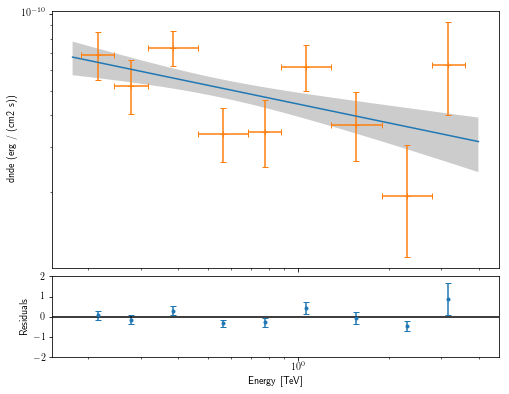

In [127]:
ax = ana.spectrum_result.plot(
    energy_range=ana.fit.fit_range,
    energy_power=2,
    flux_unit='erg-1 cm-2 s-1',
    fig_kwargs=dict(figsize = (8,8)),
)
ax[1].set_ylim(-2, 2)

In [128]:
ff = fits.open("VEGAS/CrabDL3medPoint_s6.fits")
points = ff[1].data
fit = ff[2].data

points = points[points['Significance'] > 2]
points = points[points['On'] > 2]

energy = np.array(points['Energy']) * u.TeV
flux = np.array(points['Flux'])*u.Unit("TeV-1 m-2 s-1")
fluxE = np.array(points['FluxError'])*u.Unit("TeV-1 m-2 s-1")

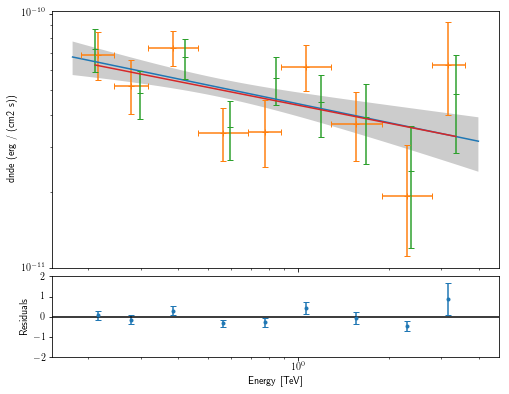

In [144]:
ax = ana.spectrum_result.plot(
    energy_range=ana.fit.fit_range,
    energy_power=2,
    flux_unit='erg-1 cm-2 s-1',
    fig_kwargs=dict(figsize = (8,8)),
)
ax[1].set_ylim(-2, 2)


ax[0].errorbar(energy.value, 
             (flux * energy**2).to(u.Unit("erg cm-2 s-1")).value, 
             yerr = (fluxE * energy**2).to(u.Unit("erg cm-2 s-1")).value, 
             ls = "", marker = "_")


ax[0].plot(energy.value, 
          (fit["Normalization"][0]*u.Unit("TeV-1 m-2 s-1") * energy.value**fit["Index"][0] * energy**2).to(u.Unit("erg cm-2 s-1")).value)


ax[0].set_ylim(ymin = 1e-11)

plt.savefig("spec_comp.pdf")

In [135]:
import plottingFunctions as pF

default colormap is now  ds9b


You are giving the normalization at 1.000
Yet the decorrelation energy is at  0.481
You might consider updating your normalization energy and rerunning.


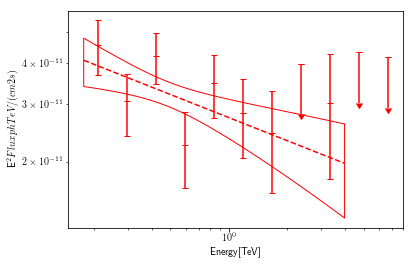

In [139]:
spec = pF.spectrumPlotter()
spec.readVEGASFits("VEGAS/CrabDL3medPoint_s6.fits")
spec.e2fluxUnits = u.Unit("erg cm-2 s-1")
spec.plotSpectrum()


In [143]:
spec.

{'E2 flux density': Unit("TeV / (cm2 s)"),
 u'energy': Unit("TeV"),
 u'unknown': Unit("ph / (cm2 s TeV)")}

In [133]:
points['EBinHiEdge']

array([ 0.2512,  0.3548,  0.5012,  0.7079,  1.    ,  1.4125,  1.9953,
        2.8184,  3.9811])